In [1]:
!pip install --upgrade transformers huggingface_hub accelerate

In [5]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 32.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

model_id = "meta-llama/Llama-3.1-8B-Instruct"
quant_config = BitsAndBytesConfig(
    load_in_4bit=True
)

tokenizer = AutoTokenizer.from_pretrained(model_id, use_auth_token=huggingface_token)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    use_auth_token=huggingface_token,
    device_map="auto",
    quantization_config=quant_config
)


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:810: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:471: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [12]:
import json
import hashlib
import requests
import re

In [13]:
def fast_extract_sentences(text):
    # Split on sentence-ending punctuation
    sentences = re.split(r'(?:[.!?]\s+)', text)
    # Remove any empty strings or extra whitespace
    return [sentence.strip() for sentence in sentences if sentence.strip()]

# Function to extract sentences from a .txt file
def extract_sentences_from_text_file(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    # Use fast method to split text into sentences
    sentences = fast_extract_sentences(text)
    return sentences

# Query BERN2 for named entity recognition
def query_raw(text, url="http://bern2.korea.ac.kr/plain"):
    try:
        return requests.post(url, json={'text': text}).json()
    except:
        print('Invalid sentence')
        return None

# Extract entities from the BERN2 response
def extract_entities(entities):
    if not entities.get('annotations'):
        return {'text': entities['text'], 'text_sha256': hashlib.sha256(entities['text'].encode('utf-8')).hexdigest()}

    e = []
    for entity in entities['annotations']:
        other_ids = [id for id in entity['id'] if not id.startswith("BERN")]
        entity_type = entity['obj']
        entity_name = entities['text'][entity['span']['begin']:entity['span']['end']]
        entity_id = next((id for id in entity['id'] if id.startswith("BERN")), entity_name)
        e.append({
            'entity_id': entity_id,
            'other_ids': other_ids,
            'entity_type': entity_type,
            'entity': entity_name
        })

    return {'entities': e, 'text': entities['text'], 'text_sha256': hashlib.sha256(entities['text'].encode('utf-8')).hexdigest()}


In [18]:
# Correct file path (ensure it points to the correct .txt file location)
text_file_path = '/content/drive/MyDrive/top_10_abstracts.txt'  # Replace with your actual file path

# Extract sentences from the text file
sentences_list = extract_sentences_from_text_file(text_file_path)

# Query BERN2 for each sentence
entity_list = [query_raw(s) for s in sentences_list if query_raw(s)]

# Parse extracted entities
parsed_entities = [extract_entities(entities) for entities in entity_list]

# Save results to JSON
with open('/content/drive/MyDrive/abstract_entities.json', 'w') as file:
    json.dump(parsed_entities, file, indent=4)

print("Named entities and relationships have been extracted and saved to 'abstract_entities.json'.")


Named entities and relationships have been extracted and saved to 'abstract_entities.json'.


In [22]:
# Function to query Llama 3.1 for relationship extraction
def extract_relationships_with_llama(sentence, entities):
    # Create the prompt for the LLM
    prompt = (
        f"The following text contains entities:\n\n{sentence}\n\n"
        f"Entities:\n{entities}\n\n"
        "Identify relationships between these entities and classify them into one of the following categories: "
        "Positive association, Negative association, Positive correlation, Negative correlation, Neutral.\n\n"
        "Output the relationships in a structured format: Each row should contain [Source Entity, Target Entity, Relationship].\n"
        "Relationships:"
    )

      # Generate output
    with torch.inference_mode():
        # Tokenize and move to device
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True).to("cuda")

        # Record how many tokens are in the prompt
        start_index = inputs["input_ids"].shape[-1]

        # Generate
        outputs = model.generate(**inputs, max_new_tokens=1500)
        new_tokens = outputs[0][start_index:]

        # Decode new tokens only (exclude prompt)
        result_text = tokenizer.decode(new_tokens, skip_special_tokens=True)

    return result_text


In [23]:
def process_json_for_relationships(json_file_path, output_file):
    # Load parsed entities JSON
    with open(json_file_path, 'r') as file:
        parsed_entities = json.load(file)

    # Iterate through parsed entities and extract relationships
    relationships = []
    for entity_data in parsed_entities:
        sentence = entity_data['text']
        entities = entity_data.get('entities', [])
        if entities:
            relationships.append({
                "sentence": sentence,
                "entities": entities,
                "relationships": extract_relationships_with_llama(sentence, entities)
            })

    # Save relationships to JSON file
    with open(output_file, 'w') as file:
        json.dump(relationships, file, indent=4)
    print(f"Relationships extracted and saved to {output_file}")


In [24]:
   input_json = 'abstract_entities.json'  # JSON file with parsed entities
   output_json = '/content/drive/MyDrive/entity_relationships_v2.json'  # JSON file to save relationships

   process_json_for_relationships(input_json, output_json)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

Relationships extracted and saved to /content/drive/MyDrive/entity_relationships_v2.json


In [26]:
import json
import pandas as pd

# Load raw output from a JSON file
with open('/content/drive/MyDrive/entity_relationships_v2.json', 'r') as file:
    raw_output = json.load(file)  # raw_output is now a list

# Function to extract only the relevant table
def extract_relationships_table(raw_output_list):
    relationships = []

    for entry in raw_output_list:  # Iterate through each entry in the list
        # Ensure entry is a dictionary and contains the "relationships" key
        if isinstance(entry, dict) and "relationships" in entry:
            relationships_text = entry["relationships"]

            # Split the text into rows
            rows = [row.strip() for row in relationships_text.split("\n") if row.strip() and row.startswith("|")]

            # Parse rows into a structured format
            for row in rows:
                columns = [col.strip() for col in row.split("|")[1:-1]]
                if len(columns) == 3:
                    relationships.append({
                        "Source Entity": columns[0],
                        "Target Entity": columns[1],
                        "Relationship": columns[2]
                    })

    # Convert to DataFrame
    return pd.DataFrame(relationships)

# Extract the relationships table
relationships_df = extract_relationships_table(raw_output)

# Display the cleaned DataFrame
print(relationships_df)


                   Source Entity                Target Entity  \
0                  Source Entity                Target Entity   
1         ----------------------       ----------------------   
2                           mice                 commensalism   
3                           mice                 evolutionary   
4                           mice                       immune   
..                           ...                          ...   
898                   CHEBI:5587  [h<sup>+</sup>]<sub>o</sub>   
899                Source Entity                Target Entity   
900                          ---                          ---   
901  [h<sup>+</sup>]<sub>o</sub>                   CHEBI:5587   
902                   CHEBI:5587  [h<sup>+</sup>]<sub>o</sub>   

               Relationship  
0              Relationship  
1    ----------------------  
2      Positive association  
3      Positive association  
4      Positive association  
..                      ...  
898    Po

In [27]:
# Save to CSV if needed
relationships_df.to_csv("entity_relationships.csv", index=False)
print("Cleaned relationships saved to 'cleaned_relationships.csv'")

Cleaned relationships saved to 'cleaned_relationships.csv'


In [31]:
print(relationships_df)

                   Source Entity                Target Entity  \
1         ----------------------       ----------------------   
2                           mice                 commensalism   
3                           mice                 evolutionary   
4                           mice                       immune   
5                           mice              laboratory mice   
..                           ...                          ...   
897  [h<sup>+</sup>]<sub>o</sub>                   CHEBI:5587   
898                   CHEBI:5587  [h<sup>+</sup>]<sub>o</sub>   
900                          ---                          ---   
901  [h<sup>+</sup>]<sub>o</sub>                   CHEBI:5587   
902                   CHEBI:5587  [h<sup>+</sup>]<sub>o</sub>   

               Relationship      Abstract  
1    ----------------------    Abstract 2  
2      Positive association    Abstract 2  
3      Positive association    Abstract 2  
4      Positive association    Abstract 2  

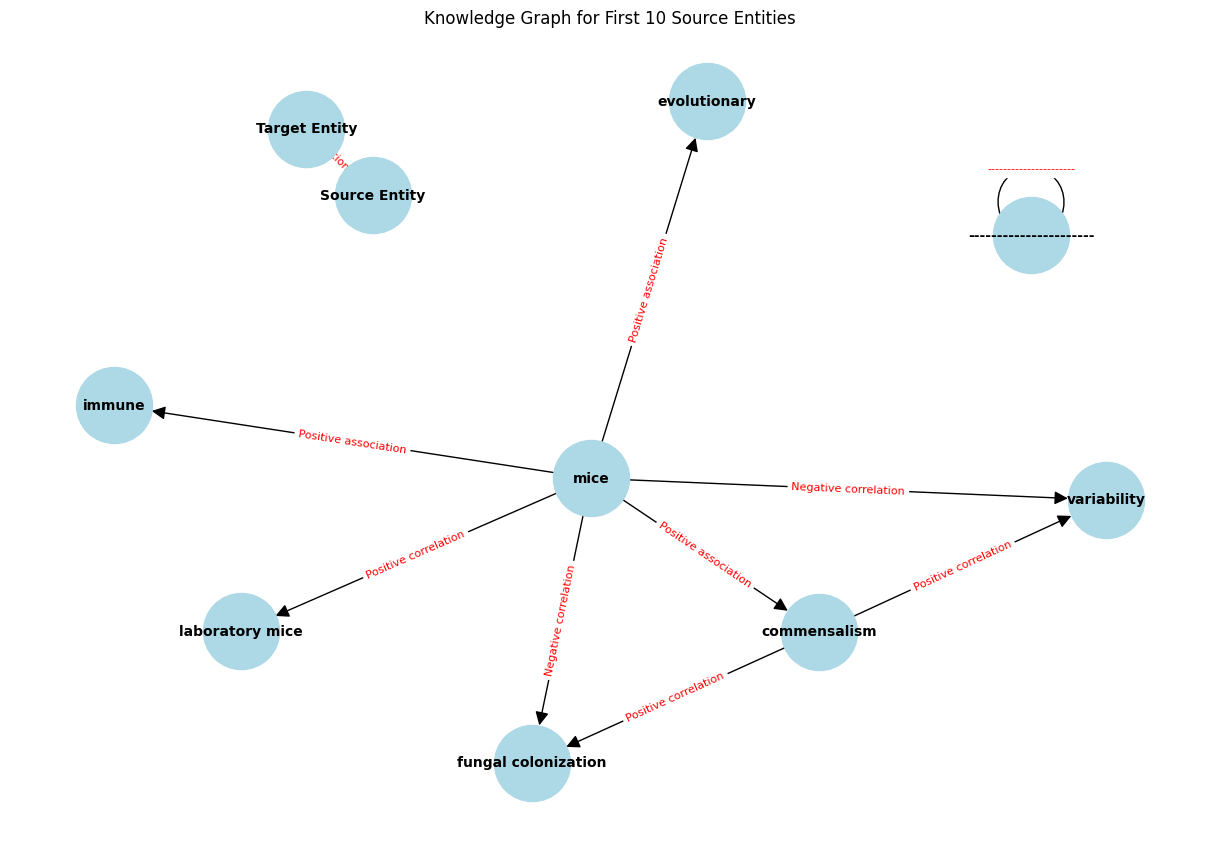

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
# Load the processed dataset (replace 'processed_data_with_abstracts.csv' with your actual file path)
df = pd.read_csv("entity_relationships.csv")

# Select the first 10 rows of the DataFrame for the knowledge graph
plot_data = df.head(10)

# Create a directed graph
G = nx.DiGraph()

# Add edges with relationships from the DataFrame
for index, row in plot_data.iterrows():
    source = row['Source Entity']
    target = row['Target Entity']
    relationship = row['Relationship']
    G.add_edge(source, target, label=relationship)

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)

# Draw nodes and edges
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=10, font_weight='bold', arrowsize=20)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=8)

plt.title("Knowledge Graph for First 10 Source Entities")
plt.show()